In [6]:
!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity
License(s): Attribution 4.0 International (CC BY 4.0)




  0%|          | 0.00/204M [00:00<?, ?B/s]
 35%|███▌      | 72.0M/204M [00:00<00:00, 746MB/s]
 71%|███████   | 144M/204M [00:00<00:00, 742MB/s] 
100%|██████████| 204M/204M [00:00<00:00, 737MB/s]


In [10]:
import zipfile

with zipfile.ZipFile("knee-osteoarthritis-dataset-with-severity.zip", "r") as zip_ref:
    zip_ref.extractall("knee_osteoarthritis_dataset")

print("Dataset extracted to: knee_osteoarthritis_dataset/")


Dataset extracted to: knee_osteoarthritis_dataset/


In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models,utils
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [2]:
BASE_DIR='E:\Learning Zone\DL\Mini project\knee_osteoarthritis_dataset'
train_path=os.path.join(BASE_DIR,'train')
val_path=os.path.join(BASE_DIR,'val')
test_path=os.path.join(BASE_DIR,'test')

In [3]:
def load_data(Data,path):
    image_path=[]
    labels=[]
    classes=sorted(os.listdir(path))
    for class_name in classes:
        class_dir=os.path.join(path,class_name)
        for img in os.listdir(class_dir):
            img_path=os.path.join(class_dir,img)
            if os.path.isfile(img_path):
                image_path.append(img_path)
                labels.append(class_name)
    
    class_to_int={class_name:idx for idx, class_name in enumerate(classes)}
    labels=[class_to_int[label] for label in labels]
    data=pd.DataFrame({
        'Image_path':image_path,
        'Label':labels
    })
    print(Data,'Distribution')
    distribution=data['Label'].value_counts().to_dict()
    print(distribution,'\n')
    return data
    

In [4]:
train_data=load_data('Train',train_path)
val_data=load_data('Validation',val_path)
test_data=load_data('Test',test_path)

Train Distribution
{0: 2286, 2: 1516, 1: 1046, 3: 757, 4: 173} 

Validation Distribution
{0: 328, 2: 212, 1: 153, 3: 106, 4: 27} 

Test Distribution
{0: 639, 2: 447, 1: 296, 3: 223, 4: 51} 



In [5]:
train_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])

])
test_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])

])

In [6]:
class KneeDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df=df.reset_index(drop=True)
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        img_path = self.df.loc[index, 'Image_path']
        label = int(self.df.loc[index, 'Label'])  
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


        

In [7]:
train_dataset=KneeDataset(train_data,train_transform)
val_dataset=KneeDataset(val_data,val_transform)
test_dataset=KneeDataset(test_data,val_transform)

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=0)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False,num_workers=0)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=0)


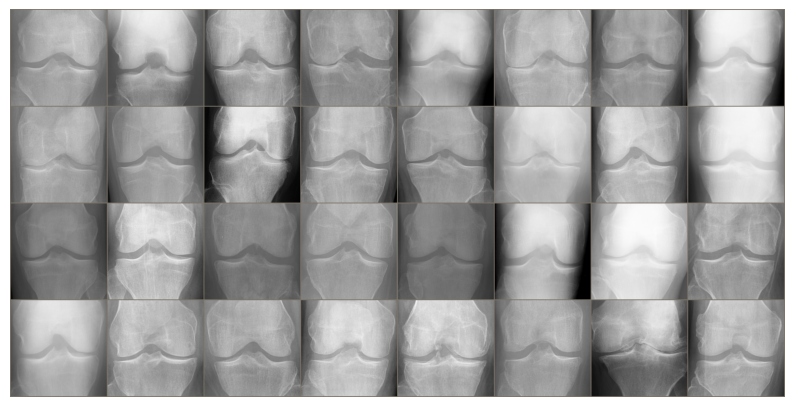

In [8]:
def visulaize_img(img):
    img=img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img =img*std +mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

image,label=next(iter(train_loader))
out=utils.make_grid(image)
plt.figure(figsize=(10,10))
visulaize_img(out)
plt.show()

In [9]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

c:\Users\Pradeesh\anaconda3\envs\miniproject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pradeesh\anaconda3\envs\miniproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model=model.to(device)

In [11]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
from sklearn.utils.class_weight import compute_class_weight
labels=train_data['Label'].values
class_weights=compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [13]:
criterion= nn.CrossEntropyLoss(weight=class_weights)
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [16]:
train_data=pd.concat([train_data,val_data,test_data],ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_dataset = KneeDataset(train_data, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

In [17]:
NUM_EPOCHS=50
patience=15
best_val_loss=float('inf')
early_stop_counter=0
model_path='best_model.pth'

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss=0.0
    correct=0
    total=0
    for images,labels in tqdm(train_loader):
        images=images.to(device)
        labels=labels.to(device)
         
        outputs=model(images)
        loss=criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    train_acc=100 *correct /total
    train_loss=running_loss/len(train_loader)

    model.eval()
    val_loss=0.0
    val_correct=0
    val_total=0

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels=labels.to(device)

            outputs=model(images)
            loss=criterion(outputs,labels)

            val_loss+=loss.item()
            _,predicted=torch.max(outputs.data,1)
            val_total+=labels.size(0)
            val_correct+=(predicted==labels).sum().item()
    val_acc=100*val_correct/val_total
    val_loss=val_loss/len(val_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}],"
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%",
          f"Val Loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%"
          )
    if val_loss<best_val_loss:
        best_val_loss=val_loss
        early_stop_counter=0
        torch.save(model.state_dict(),model_path)
        print("Validation loss decreased. Saving model...")
    else:
        early_stop_counter += 1
        print(f" No improvement. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print(" Early stopping triggered. Training stopped.")
            break



100%|██████████| 284/284 [01:44<00:00,  2.73it/s]


Epoch [1/50],Train Loss: 0.6296, Train Acc: 68.17% Val Loss: 1.5581, Val acc: 67.33%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:48<00:00,  2.63it/s]


Epoch [2/50],Train Loss: 0.5715, Train Acc: 70.48% Val Loss: 1.4873, Val acc: 67.27%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [02:00<00:00,  2.37it/s]


Epoch [3/50],Train Loss: 0.5507, Train Acc: 72.65% Val Loss: 1.6487, Val acc: 61.11%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:20<00:00,  3.54it/s]


Epoch [4/50],Train Loss: 0.4924, Train Acc: 74.87% Val Loss: 1.3396, Val acc: 71.56%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:11<00:00,  3.95it/s]


Epoch [5/50],Train Loss: 0.4375, Train Acc: 77.51% Val Loss: 1.5971, Val acc: 65.28%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:10<00:00,  4.02it/s]


Epoch [6/50],Train Loss: 0.4193, Train Acc: 78.67% Val Loss: 1.4241, Val acc: 72.10%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:10<00:00,  4.03it/s]


Epoch [7/50],Train Loss: 0.4108, Train Acc: 80.41% Val Loss: 1.3543, Val acc: 71.50%
 No improvement. Early stop counter: 3/15


100%|██████████| 284/284 [01:09<00:00,  4.06it/s]


Epoch [8/50],Train Loss: 0.3504, Train Acc: 83.49% Val Loss: 0.8891, Val acc: 82.25%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:10<00:00,  4.06it/s]


Epoch [9/50],Train Loss: 0.2688, Train Acc: 87.11% Val Loss: 0.5632, Val acc: 89.37%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:12<00:00,  3.90it/s]


Epoch [10/50],Train Loss: 0.2546, Train Acc: 88.50% Val Loss: 0.5632, Val acc: 90.34%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:09<00:00,  4.11it/s]


Epoch [11/50],Train Loss: 0.2225, Train Acc: 89.65% Val Loss: 0.6114, Val acc: 87.02%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:12<00:00,  3.93it/s]


Epoch [12/50],Train Loss: 0.1747, Train Acc: 91.65% Val Loss: 0.4051, Val acc: 92.87%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:42<00:00,  2.78it/s]


Epoch [13/50],Train Loss: 0.1709, Train Acc: 92.65% Val Loss: 1.0366, Val acc: 81.70%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:37<00:00,  2.91it/s]


Epoch [14/50],Train Loss: 0.1691, Train Acc: 92.19% Val Loss: 0.5321, Val acc: 90.28%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [02:00<00:00,  2.36it/s]


Epoch [15/50],Train Loss: 0.1292, Train Acc: 94.17% Val Loss: 0.2436, Val acc: 95.95%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:26<00:00,  3.27it/s]


Epoch [16/50],Train Loss: 0.1054, Train Acc: 95.31% Val Loss: 0.6237, Val acc: 88.47%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:40<00:00,  2.82it/s]


Epoch [17/50],Train Loss: 0.1471, Train Acc: 93.86% Val Loss: 0.2176, Val acc: 95.77%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:43<00:00,  2.75it/s]


Epoch [18/50],Train Loss: 0.1016, Train Acc: 95.30% Val Loss: 0.1725, Val acc: 97.04%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:29<00:00,  3.18it/s]


Epoch [19/50],Train Loss: 0.0819, Train Acc: 96.57% Val Loss: 0.1839, Val acc: 97.10%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:19<00:00,  3.58it/s]


Epoch [20/50],Train Loss: 0.0929, Train Acc: 95.97% Val Loss: 0.2020, Val acc: 96.26%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:16<00:00,  3.71it/s]


Epoch [21/50],Train Loss: 0.0773, Train Acc: 96.53% Val Loss: 0.2994, Val acc: 94.75%
 No improvement. Early stop counter: 3/15


100%|██████████| 284/284 [01:16<00:00,  3.70it/s]


Epoch [22/50],Train Loss: 0.0764, Train Acc: 96.61% Val Loss: 0.1959, Val acc: 96.38%
 No improvement. Early stop counter: 4/15


100%|██████████| 284/284 [01:08<00:00,  4.12it/s]


Epoch [23/50],Train Loss: 0.0824, Train Acc: 96.31% Val Loss: 0.2371, Val acc: 94.93%
 No improvement. Early stop counter: 5/15


100%|██████████| 284/284 [01:11<00:00,  3.95it/s]


Epoch [24/50],Train Loss: 0.0903, Train Acc: 95.92% Val Loss: 0.1772, Val acc: 96.56%
 No improvement. Early stop counter: 6/15


100%|██████████| 284/284 [01:08<00:00,  4.15it/s]


Epoch [25/50],Train Loss: 0.0645, Train Acc: 96.96% Val Loss: 0.2342, Val acc: 95.35%
 No improvement. Early stop counter: 7/15


100%|██████████| 284/284 [01:35<00:00,  2.97it/s]


Epoch [26/50],Train Loss: 0.0633, Train Acc: 97.02% Val Loss: 0.1647, Val acc: 96.86%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:27<00:00,  3.24it/s]


Epoch [27/50],Train Loss: 0.0473, Train Acc: 97.88% Val Loss: 0.2135, Val acc: 96.32%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:24<00:00,  3.38it/s]


Epoch [28/50],Train Loss: 0.1512, Train Acc: 94.13% Val Loss: 0.2237, Val acc: 95.95%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:05<00:00,  4.33it/s]


Epoch [29/50],Train Loss: 0.0784, Train Acc: 96.75% Val Loss: 0.1182, Val acc: 97.77%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:03<00:00,  4.51it/s]


Epoch [30/50],Train Loss: 0.0817, Train Acc: 96.80% Val Loss: 0.1291, Val acc: 97.64%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:01<00:00,  4.64it/s]


Epoch [31/50],Train Loss: 0.0465, Train Acc: 97.86% Val Loss: 0.1368, Val acc: 97.58%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:01<00:00,  4.64it/s]


Epoch [32/50],Train Loss: 0.0322, Train Acc: 98.65% Val Loss: 0.1707, Val acc: 97.58%
 No improvement. Early stop counter: 3/15


100%|██████████| 284/284 [01:03<00:00,  4.49it/s]


Epoch [33/50],Train Loss: 0.0413, Train Acc: 98.22% Val Loss: 0.0737, Val acc: 98.49%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [00:58<00:00,  4.82it/s]


Epoch [34/50],Train Loss: 0.0415, Train Acc: 98.17% Val Loss: 0.3584, Val acc: 95.35%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:02<00:00,  4.51it/s]


Epoch [35/50],Train Loss: 0.0908, Train Acc: 96.43% Val Loss: 0.0952, Val acc: 98.25%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:05<00:00,  4.34it/s]


Epoch [36/50],Train Loss: 0.0493, Train Acc: 97.85% Val Loss: 0.1421, Val acc: 97.83%
 No improvement. Early stop counter: 3/15


100%|██████████| 284/284 [01:10<00:00,  4.04it/s]


Epoch [37/50],Train Loss: 0.0496, Train Acc: 97.96% Val Loss: 0.1005, Val acc: 98.37%
 No improvement. Early stop counter: 4/15


100%|██████████| 284/284 [01:18<00:00,  3.60it/s]


Epoch [38/50],Train Loss: 0.0333, Train Acc: 98.48% Val Loss: 0.1156, Val acc: 97.83%
 No improvement. Early stop counter: 5/15


100%|██████████| 284/284 [01:10<00:00,  4.04it/s]


Epoch [39/50],Train Loss: 0.0621, Train Acc: 97.66% Val Loss: 0.0855, Val acc: 98.67%
 No improvement. Early stop counter: 6/15


100%|██████████| 284/284 [01:08<00:00,  4.15it/s]


Epoch [40/50],Train Loss: 0.0520, Train Acc: 97.71% Val Loss: 0.1098, Val acc: 97.95%
 No improvement. Early stop counter: 7/15


100%|██████████| 284/284 [01:08<00:00,  4.15it/s]


Epoch [41/50],Train Loss: 0.0524, Train Acc: 97.68% Val Loss: 0.1134, Val acc: 98.13%
 No improvement. Early stop counter: 8/15


100%|██████████| 284/284 [01:11<00:00,  3.99it/s]


Epoch [42/50],Train Loss: 0.0296, Train Acc: 98.76% Val Loss: 0.0316, Val acc: 99.58%
Validation loss decreased. Saving model...


100%|██████████| 284/284 [01:23<00:00,  3.39it/s]


Epoch [43/50],Train Loss: 0.0276, Train Acc: 98.81% Val Loss: 0.0496, Val acc: 99.21%
 No improvement. Early stop counter: 1/15


100%|██████████| 284/284 [01:07<00:00,  4.18it/s]


Epoch [44/50],Train Loss: 0.0489, Train Acc: 97.99% Val Loss: 0.1002, Val acc: 98.31%
 No improvement. Early stop counter: 2/15


100%|██████████| 284/284 [01:27<00:00,  3.23it/s]


Epoch [45/50],Train Loss: 0.0916, Train Acc: 96.40% Val Loss: 0.1107, Val acc: 97.95%
 No improvement. Early stop counter: 3/15


100%|██████████| 284/284 [01:30<00:00,  3.14it/s]


Epoch [46/50],Train Loss: 0.0412, Train Acc: 98.18% Val Loss: 0.0380, Val acc: 99.28%
 No improvement. Early stop counter: 4/15


100%|██████████| 284/284 [01:22<00:00,  3.43it/s]


Epoch [47/50],Train Loss: 0.0316, Train Acc: 98.57% Val Loss: 0.1182, Val acc: 97.95%
 No improvement. Early stop counter: 5/15


100%|██████████| 284/284 [01:29<00:00,  3.18it/s]


Epoch [48/50],Train Loss: 0.0365, Train Acc: 98.54% Val Loss: 0.0650, Val acc: 98.97%
 No improvement. Early stop counter: 6/15


100%|██████████| 284/284 [01:17<00:00,  3.67it/s]


Epoch [49/50],Train Loss: 0.0234, Train Acc: 98.83% Val Loss: 0.0975, Val acc: 98.25%
 No improvement. Early stop counter: 7/15


100%|██████████| 284/284 [01:00<00:00,  4.71it/s]


Epoch [50/50],Train Loss: 0.0317, Train Acc: 98.70% Val Loss: 0.1105, Val acc: 98.01%
 No improvement. Early stop counter: 8/15


In [20]:
model=models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc=nn.Linear(num_ftrs,5)
model=model.to(device)

In [21]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

C:\Users\Pradeesh\AppData\Local\Temp\ipykernel_19304\4153271655.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [24]:
prediction=[]
labels=[]
with torch.no_grad():
    for images,label in test_loader:
        images=images.to(device)
        label=label.to(device)
        outputs=model(images)
        _,preds=torch.max(outputs,1)
        prediction.extend(preds.cpu().numpy())
        labels.extend(label.cpu().numpy())
print('Accuracy: ',accuracy_score(labels,prediction))
print('\n')
print('Confusion Matrix: ',confusion_matrix(labels,prediction))
print(classification_report(labels,prediction))

Accuracy:  0.9957729468599034


Confusion Matrix:  [[636   3   0   0   0]
 [  1 295   0   0   0]
 [  1   2 444   0   0]
 [  0   0   0 223   0]
 [  0   0   0   0  51]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       639
           1       0.98      1.00      0.99       296
           2       1.00      0.99      1.00       447
           3       1.00      1.00      1.00       223
           4       1.00      1.00      1.00        51

    accuracy                           1.00      1656
   macro avg       1.00      1.00      1.00      1656
weighted avg       1.00      1.00      1.00      1656

